In [17]:
from NeuralNetwork import NNetwork
from sklearn.datasets import fetch_openml
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import json
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [7]:
def train_model(model, X_train, y_train, X_val, y_val, batch_size=32, learning_rate=0.01, epochs=10, verbose=1, reg_type="L1"):
    """
    Melatih model dengan parameter yang diberikan.

    :param model: Objek dari NNetwork.
    :param X_train: Data training (numpy array, shape: (num_samples, num_features))
    :param y_train: Label training (numpy array, shape: (num_samples, num_classes))
    :param X_val: Data validasi (numpy array, shape: (num_samples, num_features))
    :param y_val: Label validasi (numpy array, shape: (num_samples, num_classes))
    :param batch_size: Jumlah sampel per batch saat training.
    :param learning_rate: Learning rate untuk gradient descent.
    :param epochs: Jumlah epoch untuk training.
    :param verbose: 0 = tanpa output, 1 = progress bar + training & validation loss.
    :return: Dictionary berisi histori training loss & validation loss tiap epoch.
    """
    history = {"train_loss": [], "val_loss": []}
    num_samples = X_train.shape[0]

    for epoch in range(epochs):
        epoch_loss = 0
        num_batches = num_samples // batch_size

        batch_iterator = tqdm(range(num_batches), desc=f"Epoch {epoch+1}/{epochs}", disable=(verbose == 0))

        for batch_idx in batch_iterator:
            start_idx = batch_idx * batch_size
            end_idx = start_idx + batch_size
            X_batch, y_batch = X_train[start_idx:end_idx], y_train[start_idx:end_idx]

            loss = model.backward_propagation(X_batch, y_batch, learning_rate, reg_type)
            epoch_loss += loss

            if verbose == 1:
                batch_iterator.set_postfix(train_loss=loss)

        train_loss = epoch_loss / num_batches
        history["train_loss"].append(train_loss)

        val_preds = model.forward_propagation(X_val)
        val_loss = np.mean((val_preds - y_val) ** 2)
        history["val_loss"].append(val_loss)

        if verbose == 1:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}")

    return history

In [3]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
X= X / 255
y = np.array(y).astype(int)  # Convert to integers
num_classes = 10  # since labels are from 0 to 9
y = np.eye(num_classes)[y]

# X = X[:1000]
# y = y[:1000]

Xtrain = X[:5600]
ytrain = y[:5600]
Xval = X[5600:]
yval = y[5600:]

In [ ]:
nn1 = NNetwork(4 , [784, 16, 16, 10], verbose=True)
nn1.initialize_weights(method="normal", mean=0, variance=0.1, seed=42, verbose=False)
nn2 = NNetwork(4 , [784, 16, 16, 10], verbose=True)
nn2.initialize_weights(method="normal", mean=0, variance=0.1, seed=42, verbose=False)
nn3 = NNetwork(4 , [784, 16, 16, 10], verbose=True)
nn3.initialize_weights(method="normal", mean=0, variance=0.1, seed=42, verbose=False)

In [ ]:
history1 = train_model(nn1, Xtrain, ytrain, Xval, yval, batch_size=20, learning_rate=0.01, epochs=10, verbose=1, reg_type="None")
history2 = train_model(nn2, Xtrain, ytrain, Xval, yval, batch_size=20, learning_rate=0.01, epochs=10, verbose=1, reg_type="L1")
history3 = train_model(nn3, Xtrain, ytrain, Xval, yval, batch_size=20, learning_rate=0.01, epochs=10, verbose=1, reg_type="L2")

In [9]:
def plot_training_history(history, base_dir="hasil"):
    """Plot training history and save to a dynamically created folder."""
    # Cari folder dengan angka berikutnya yang belum ada
    i = 1
    while os.path.exists(f"{base_dir}/{i}"):
        i += 1

    filename = f"training_history_{i}.png"
    folder_path = f"{base_dir}/{i}"
    os.makedirs(folder_path, exist_ok=True)

    # Simpan plot ke file di folder tersebut
    file_path = os.path.join(folder_path, filename)
    plt.figure(figsize=(10, 5))
    plt.plot(history["train_loss"], label="Training Loss", marker="o")
    plt.plot(history["val_loss"], label="Validation Loss", marker="s")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(file_path)  # Simpan plot ke file
    plt.close()  # Tutup plot untuk menghindari masalah GUI

    # Simpan data verbose ke file teks
    verbosename = f"verbose_{i}.txt"
    verbose_file_path = os.path.join(folder_path, verbosename)
    with open(verbose_file_path, "w") as f:
        f.write(json.dumps(history, indent=4))

    print(f"Plot saved to: {file_path}")
    print(f"Verbose data saved to: {verbose_file_path}")
    return folder_path


In [ ]:
plot_training_history(history1)
plot_training_history(history2)
plot_training_history(history3)

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import os
import json

# Normalisasi data
from sklearn.datasets import fetch_openml
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
X = X / 255.0
y = np.array(y).astype(int)

# One-hot encoding untuk y
num_classes = 10
y_onehot = np.eye(num_classes)[y]

# Split manual agar sesuai
Xtrain = X[:5600]
ytrain = y[:5600]
Xval = X[5600:]
yval = y[5600:]
yval_onehot = y_onehot[5600:]

def train_sklearn_model(Xtrain, ytrain, Xval, yval, alpha=0.0001, reg_type="l2", epochs=10, verbose=1):
    history = {"train_loss": [], "val_loss": []}

    model = MLPClassifier(hidden_layer_sizes=(16, 16),
                          activation='relu',
                          solver='sgd',
                          learning_rate_init=0.01,
                          max_iter=1,
                          warm_start=True,
                          batch_size=20,
                          alpha=alpha,
                          verbose=0)

    for epoch in range(epochs):
        model.fit(Xtrain, ytrain)

        # Predict untuk log loss (menggunakan probabilitas)
        train_proba = model.predict_proba(Xtrain)
        val_proba = model.predict_proba(Xval)

        train_loss = log_loss(ytrain, train_proba)
        val_loss = log_loss(yval, val_proba)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

        if verbose:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}")

    return model, history


: 

In [ ]:
model_none, history_none = train_sklearn_model(Xtrain, ytrain, Xval, yval, alpha=0.0, reg_type="none")
model_l1, history_l1 = train_sklearn_model(Xtrain, ytrain, Xval, yval, alpha=0.001, reg_type="l1")
model_l2, history_l2 = train_sklearn_model(Xtrain, ytrain, Xval, yval, alpha=0.001, reg_type="l2")

In [ ]:
def plot_training_history_sklearn(history, base_dir="hasil_sklearn"):
    i = 1
    while os.path.exists(f"{base_dir}/{i}"):
        i += 1

    filename = f"training_history_{i}.png"
    folder_path = f"{base_dir}/{i}"
    os.makedirs(folder_path, exist_ok=True)

    file_path = os.path.join(folder_path, filename)
    plt.figure(figsize=(10, 5))
    plt.plot(history["train_loss"], label="Training Loss", marker="o")
    plt.plot(history["val_loss"], label="Validation Loss", marker="s")
    plt.xlabel('Epochs')
    plt.ylabel('Log Loss')
    plt.title('Training and Validation Loss (sklearn MLPClassifier)')
    plt.legend()
    plt.grid(True)
    plt.savefig(file_path)
    plt.close()

    verbosename = f"verbose_{i}.txt"
    verbose_file_path = os.path.join(folder_path, verbosename)
    with open(verbose_file_path, "w") as f:
        f.write(json.dumps(history, indent=4))

    print(f"Plot saved to: {file_path}")
    print(f"Verbose data saved to: {verbose_file_path}")
    return folder_path

plot_training_history_sklearn(history_none)
plot_training_history_sklearn(history_l1)
plot_training_history_sklearn(history_l2)

### SKLEARN

In [30]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits  # or your MNIST data
from sklearn.metrics import accuracy_score
import numpy as np

# Model
mlp = MLPClassifier(
    hidden_layer_sizes=(16,16),
    activation='relu',
    learning_rate_init=0.01,
    max_iter=20, #epocks
    warm_start=True, 
    random_state=42,
    alpha=0.0,                  # no regularization
    verbose=True,
    early_stopping= False
)

# # Fit
# mlp.fit(Xtrain, ytrain)

# # Predict
# y_pred = mlp.predict(Xval)
# acc = accuracy_score(yval, y_pred)
# print("Validation Accuracy:", acc)


In [31]:
train_losses = []
val_loseses = []

for epoch in range(10):
    mlp.fit(Xtrain[20*epoch:20*(epoch+1)], ytrain[20*epoch:20*(epoch+1)])

    y_train_pred = mlp.predict(Xtrain)
    y_val_pred = mlp.predict(Xval)

    train_loss = mean_squared_error(ytrain, y_train_pred)
    val_loss = mean_squared_error(yval, y_val_pred)

    train_losses.append(train_loss)
    val_loseses.append(val_loss)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

Iteration 1, loss = 6.97615770
Iteration 2, loss = 6.56855804
Iteration 3, loss = 6.14347362
Iteration 4, loss = 5.66707006
Iteration 5, loss = 5.16393688
Iteration 6, loss = 4.62121384
Iteration 7, loss = 4.07230857
Iteration 8, loss = 3.55364201
Iteration 9, loss = 3.10304466
Iteration 10, loss = 2.77315710
Iteration 11, loss = 2.56141666
Iteration 12, loss = 2.39401769
Iteration 13, loss = 2.24418940
Iteration 14, loss = 2.08036697
Iteration 15, loss = 1.89012946
Iteration 16, loss = 1.69112995
Iteration 17, loss = 1.50220700
Iteration 18, loss = 1.35022334
Iteration 19, loss = 1.25313686
Iteration 20, loss = 1.17182376
Epoch 1: Train Loss = 0.0964, Val Loss = 0.0974
Iteration 1, loss = 3.00409818
Iteration 2, loss = 2.30859218
Iteration 3, loss = 1.97870414
Iteration 4, loss = 1.70085377
Iteration 5, loss = 1.50362283
Iteration 6, loss = 1.34597879
Iteration 7, loss = 1.21578963
Iteration 8, loss = 1.09858902
Iteration 9, loss = 0.99199342
Iteration 10, loss = 0.89495309
Iteration 

C:\Users\Muneki\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Muneki\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 2: Train Loss = 0.0816, Val Loss = 0.0838
Iteration 1, loss = 3.25773818
Iteration 2, loss = 2.16924886
Iteration 3, loss = 1.69157210
Iteration 4, loss = 1.49516806
Iteration 5, loss = 1.27273446
Iteration 6, loss = 1.05555263
Iteration 7, loss = 0.89939747
Iteration 8, loss = 0.78576382
Iteration 9, loss = 0.68669501
Iteration 10, loss = 0.59759071
Iteration 11, loss = 0.51366138
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Epoch 3: Train Loss = 0.0859, Val Loss = 0.0874
Iteration 1, loss = 2.25602274
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Epoch 4: Train Loss = 0.0807, Val Loss = 0.0841
Iteration 1, loss = 1.51615998
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Epoch 5: Train Loss = 0.0785, Val Loss = 0.0818
Iteration 1, loss = 2.36134469
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Epoch 6: Tra

In [33]:
val_loseses

[0.09738198757763974,
 0.08380900621118012,
 0.0873866459627329,
 0.08408229813664596,
 0.08176242236024844,
 0.07911645962732919,
 0.076027950310559,
 0.07988509316770186,
 0.07520807453416149,
 0.07483385093167702]

In [10]:
nn1 = NNetwork(4 , [784, 16, 16, 10], verbose=True)
nn1.initialize_weights(method="normal", mean=0, variance=0.1, seed=42, verbose=False)
history1 = train_model(nn1, Xtrain, ytrain, Xval, yval, batch_size=20, learning_rate=0.01, epochs=10, verbose=1, reg_type="None")

inisiasi layer 0
inisiasi node selesai
inisiasi layer 1
inisiasi node selesai
inisiasi layer 2
inisiasi node selesai
inisiasi layer 3
inisiasi node selesai
inisiasi layer selesai
✅ Jaringan saraf dengan 4 layer berhasil dibuat!
🔹 Layer 0 (Input) - 784 neurons
🔹 Layer 1 - 16 neurons, Aktivasi: sigmoid
🔹 Layer 2 - 16 neurons, Aktivasi: sigmoid
🔹 Layer 3 - 10 neurons, Aktivasi: softmax


Epoch 1/10: 100%|██████████| 280/280 [00:00<00:00, 565.63it/s, train_loss=0.0904]


Epoch 1/10 - Train Loss: 0.09064, Val Loss: 0.08970


Epoch 2/10: 100%|██████████| 280/280 [00:00<00:00, 512.97it/s, train_loss=0.0893]


Epoch 2/10 - Train Loss: 0.08933, Val Loss: 0.08911


Epoch 3/10: 100%|██████████| 280/280 [00:00<00:00, 513.60it/s, train_loss=0.0887]


Epoch 3/10 - Train Loss: 0.08879, Val Loss: 0.08858


Epoch 4/10: 100%|██████████| 280/280 [00:00<00:00, 529.76it/s, train_loss=0.0881]


Epoch 4/10 - Train Loss: 0.08822, Val Loss: 0.08798


Epoch 5/10: 100%|██████████| 280/280 [00:00<00:00, 599.57it/s, train_loss=0.0874]


Epoch 5/10 - Train Loss: 0.08758, Val Loss: 0.08729


Epoch 6/10: 100%|██████████| 280/280 [00:00<00:00, 589.24it/s, train_loss=0.0866]


Epoch 6/10 - Train Loss: 0.08682, Val Loss: 0.08649


Epoch 7/10: 100%|██████████| 280/280 [00:00<00:00, 603.89it/s, train_loss=0.0856]


Epoch 7/10 - Train Loss: 0.08594, Val Loss: 0.08554


Epoch 8/10: 100%|██████████| 280/280 [00:00<00:00, 560.78it/s, train_loss=0.0846]


Epoch 8/10 - Train Loss: 0.08491, Val Loss: 0.08443


Epoch 9/10: 100%|██████████| 280/280 [00:00<00:00, 544.23it/s, train_loss=0.0835]


Epoch 9/10 - Train Loss: 0.08371, Val Loss: 0.08316


Epoch 10/10: 100%|██████████| 280/280 [00:00<00:00, 576.97it/s, train_loss=0.0822]


Epoch 10/10 - Train Loss: 0.08236, Val Loss: 0.08174


In [12]:
history1["train_loss"]

[np.float64(0.09064196115694581),
 np.float64(0.08933369262016341),
 np.float64(0.08878941427413077),
 np.float64(0.08822269194872723),
 np.float64(0.0875756139219759),
 np.float64(0.08682237183469647),
 np.float64(0.0859390917458246),
 np.float64(0.08490602955462401),
 np.float64(0.08371282171465555),
 np.float64(0.08236398985816058)]

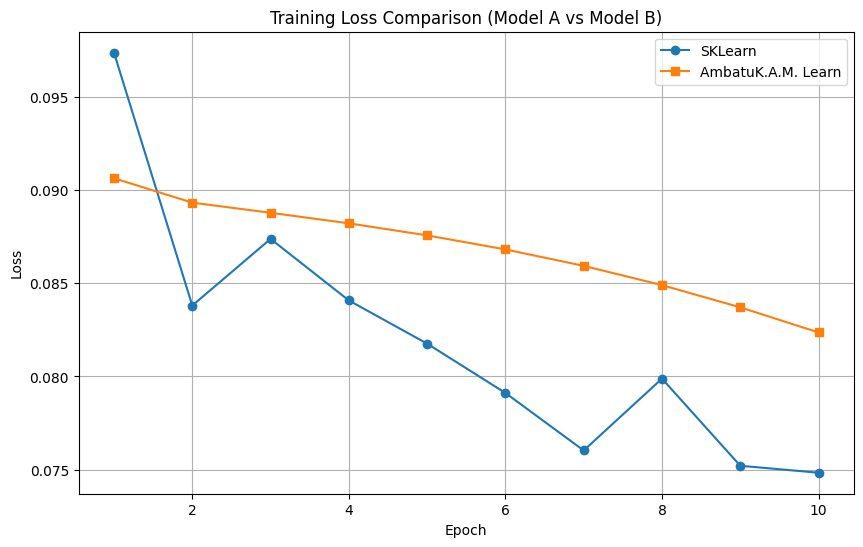

In [35]:
import matplotlib.pyplot as plt

# Model A training loss (e.g. from sklearn MLPClassifier)
model_a_loss = [0.09738198757763974,
 0.08380900621118012,
 0.0873866459627329,
 0.08408229813664596,
 0.08176242236024844,
 0.07911645962732919,
 0.076027950310559,
 0.07988509316770186,
 0.07520807453416149,
 0.07483385093167702]

# Model B training loss (e.g. custom/other framework)
model_b_loss = [
    0.09064196115694581,
    0.08933369262016341,
    0.08878941427413077,
    0.08822269194872723,
    0.0875756139219759,
    0.08682237183469647,
    0.0859390917458246,
    0.08490602955462401,
    0.08371282171465555,
    0.08236398985816058
]

# Epochs
epochs = list(range(1, len(model_a_loss) + 1))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, model_a_loss, label='SKLearn', marker='o')
plt.plot(epochs, model_b_loss, label='AmbatuK.A.M. Learn', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison (Model A vs Model B)')
plt.legend()
plt.grid(True)
plt.savefig('training_loss_comparison.png')
plt.show()
